# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [169]:
import sqlite3 as sql
import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
db = sql.connect("sf_data.sqlite")
import pysal
import shapely.geometry as geom
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 10)
#%matplotlib inline

In [3]:
query1='''
Select L2.Applicant,COUNT(DISTINCT L3.Address) AS COUNT FROM mobile_food_schedule As L1 INNER JOIN mobile_food_permits  AS L2
ON L1.permit = L2.permit 
INNER JOIN mobile_food_locations  AS L3 ON L1.locationid=L3.locationid
Group by L2.Applicant
ORDER BY COUNT DESC
'''
df2=pd.read_sql(query1, db)
df2.head()

,Applicant,COUNT
0,May Catering,58
1,Anas Goodies Catering,37
2,Natan's Catering,37
3,Liang Bai Ping,33
4,Park's Catering,23


__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

__1.2.1__  Which parts of the city are the most and least expensive?

In [4]:
query2='''
SELECT * FROM zillow
'''
df0=pd.read_sql(query2, db)
df2=df0.ix[:,[0,2,3]].dropna()
df=df2.groupby('RegionName').mean()
df.sort_values(by='MedianSoldPricePerSqft_AllHomes',ascending=False,inplace=True)
df.head()

,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes
RegionName,,
94158,4.332000,1120.358515
94105,4.251231,994.696386
94123,3.576556,987.337775
94114,3.289906,904.988180
94133,3.598333,882.532721


In [5]:
#sf_shp=zipdata[zipdata['GEOID10'].isin(map(str, set(df0['RegionName'])))]
#sf_shp.to_file('sf_shp')
#sf_shp=zipdata[zipdata['GEOID10'].isin(map(str, set(df0['RegionName'])))]
#sf_shp.to_file('sf_shp')
p=gpd.read_file('sf_shp/sf_shp.shp')
p.iloc[:,3]=p.iloc[:,3].astype(int)
price_area=p.merge(df,right_index=True, left_on='GEOID10', how='right')
p_rent=price_area.sort_values(by='ZriPerSqft_AllHomes')
p_sold=price_area.sort_values(by='MedianSoldPricePerSqft_AllHomes')

In [6]:
g_df = gpd.GeoDataFrame(p_rent)
fig=plt.figure(1,figsize=[10,10])

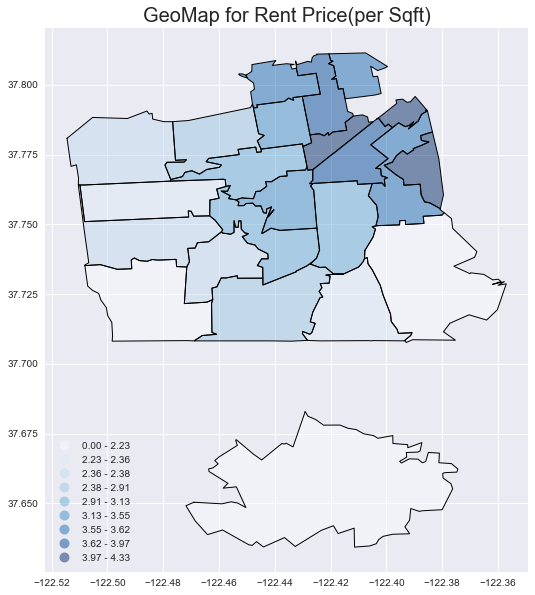

In [47]:
base = p_rent.plot(column='ZriPerSqft_AllHomes',cmap='Blues',scheme='Quantiles',legend=True,k=9)
plt.title('GeoMap for Rent Price(per Sqft)',fontsize=20)
plt.show()

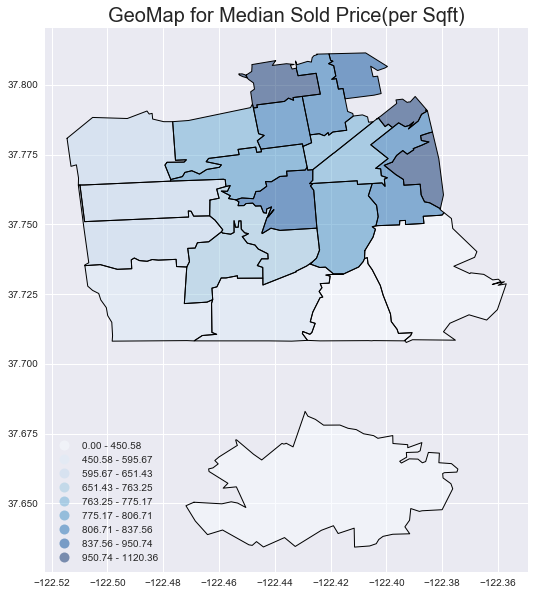

In [48]:
base = p_sold.plot(column='MedianSoldPricePerSqft_AllHomes',cmap='Blues',scheme='Quantiles',legend=True,k=9)
plt.title('GeoMap for Median Sold Price(per Sqft)',fontsize=20)
plt.show()

__1.2.2__  Which parts of the city are the most dangerous (and at what times)?

In [98]:
query3_1='''
SELECT PdDistrict,COUNT(DISTINCT IncidntNum) AS COUNT FROM crime 
WHERE  time(Datetime) between '08:00:01' and '16:00:00' 
Group by PdDistrict 
ORDER BY COUNT DESC
''' 
query3_2='''
SELECT PdDistrict,COUNT(DISTINCT IncidntNum) AS COUNT FROM crime 
WHERE  time(Datetime) between '16:00:01' and '24:00:00' 
Group by PdDistrict 
ORDER BY COUNT DESC
''' 
query3_3='''
SELECT PdDistrict,COUNT(DISTINCT IncidntNum) AS COUNT FROM crime 
WHERE  time(Datetime) between '00:00:01' and '08:00:00' 
Group by PdDistrict 
ORDER BY COUNT DESC
''' 
crime_daytime=pd.read_sql(query3_1, db)
crime_daytime['Interval']='8-16'
crime_evening=pd.read_sql(query3_2, db)
crime_evening['Interval']='16-24'
crime_night=pd.read_sql(query3_3, db)
crime_night['Interval']='0-8'
crime=pd.concat([crime_daytime,crime_evening,crime_night])

In [99]:
crime.drop(10,inplace=True)

In [100]:
crime.pivot('PdDistrict','Interval')

COUNT              
Interval      0-8  16-24   8-16
PdDistrict                     
BAYVIEW     14249  33152  28466
CENTRAL     17400  38074  34295
INGLESIDE   13198  30256  24930
MISSION     22430  43301  34448
NORTHERN    20206  43552  34656
PARK         8800  19729  19429
RICHMOND     7866  18288  18931
SOUTHERN    27678  69148  58520
TARAVAL     11054  24616  24142
TENDERLOIN  10894  22417  21700

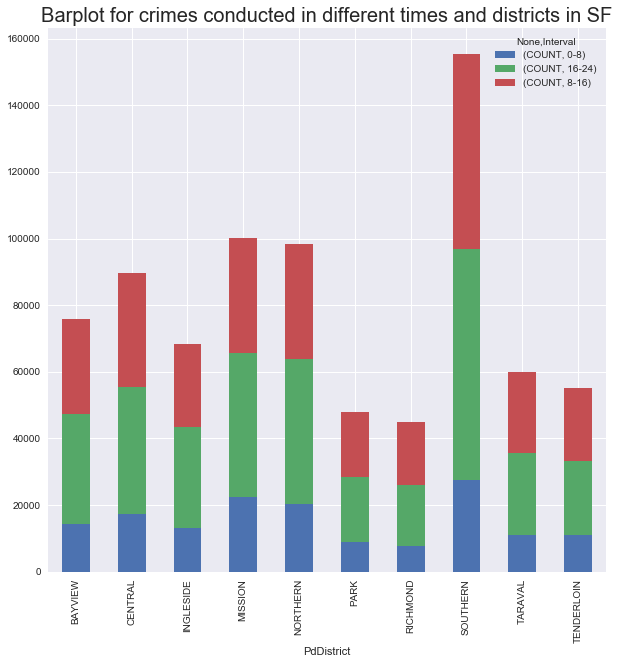

In [101]:
crime.pivot('PdDistrict','Interval').plot(kind='bar', stacked=True)
plt.title('Barplot for crimes conducted in different times and districts in SF',fontsize=20)

__1.2.3__  Are noise complaints and mobile food vendors related?

In [156]:
noise = pd.read_sql("SELECT * FROM noise",db).dropna()
vendor = pd.read_sql("SELECT * FROM mobile_food_locations",db).dropna()
vendor=vendor[vendor['Latitude']!=0]

In [212]:
def geo_map(x,l1,l2):
    '''
    extract data from database and motify it into geodataframe.
    Args:x (string): table in data base
         l1,l2:columns of geodata in this table
    Returns: d geodataframe based on table x from database
    '''
    query='SELECT * FROM '+x
    data=pd.read_sql(q1, db).dropna()
    lonlat = [geom.Point(lon, lat) for lon, lat in zip(data[l1], data[l2])]
    d = gpd.GeoDataFrame(data, geometry = lonlat, crs = {'init' :'epsg:4326'})
    return d

In [158]:
## geodataframelize
lonlat = [geom.Point(lon, lat) for lon, lat in zip(noise.Lon, noise.Lat)]
noise = gpd.GeoDataFrame(noise, geometry = lonlat, crs = {'init' :'epsg:4326'})
noise.geometry.head()

1    POINT (-122.424474850717 37.7691482064722)
2     POINT (-122.508365256702 37.762047023755)
3     POINT (-122.414943216196 37.787982901643)
4      POINT (-122.502232253358 37.76138549134)
5     POINT (-122.420087435923 37.742435250569)
Name: geometry, dtype: object

In [214]:
noise

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon,geometry
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475,POINT (-122.424474850717 37.7691482064722)
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365,POINT (-122.508365256702 37.762047023755)
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943,POINT (-122.414943216196 37.787982901643)
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232,POINT (-122.502232253358 37.76138549134)
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087,POINT (-122.420087435923 37.742435250569)
6,5661647,amplified_sound_electronics,"801 25TH AVE, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-03-13 23:27:11,37.774201,-122.484448,POINT (-122.484448215758 37.774200835749)
7,5661981,construction_public,"1275 COLUMBUS AVE, SAN FRANCISCO, CA, 94133",Fisherman's Wharf,2016-03-14 08:09:25,37.805616,-122.418177,POINT (-122.418177369469 37.805615941191)
8,6423810,other_excessive_noise,"779 LA PLAYA, SAN FRANCISCO, CA, 94121",Outer Richmond,2016-10-15 12:36:45,37.773767,-122.510212,POINT (-122.510211620936 37.773766740399)
9,5932159,amplified_sound_electronics,"1331 FOLSOM ST, SAN FRANCISCO, CA, 94103",South of Market,2016-06-01 17:48:41,37.773292,-122.411780,POINT (-122.411780181021 37.773291732112)
10,5932303,amplified_sound_electronics,Intersection of SUTTER ST and BRODERICK ST,Lower Pacific Heights,2016-06-01 18:22:47,37.785036,-122.441537,POINT (-122.441537162653 37.78503600338021)


In [213]:
geo_map('noise','Lon','Lat')

,Name,Type,Acreage,ParkID,Lat,Lon,geometry
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099,POINT (-122.46809908 37.78184397)
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268,POINT (-122.47226783 37.75956493)
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575,POINT (-122.40857543 37.75306042)
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236,POINT (-122.43523589 37.74360211)
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855,POINT (-122.38385466 37.73101645)
5,ALAMO SQUARE,Neighborhood Park or Playground,12.70,117,37.776349,-122.434674,POINT (-122.43467396 37.77634875)
6,ALICE CHALMERS PLAYGROUND,Neighborhood Park or Playground,1.68,25,37.709827,-122.446651,POINT (-122.44665065 37.7098271)
7,ALICE MARBLE TENNIS COURTS,Neighborhood Park or Playground,0.84,151,37.801428,-122.420343,POINT (-122.42034327 37.80142776)
8,ALIOTO MINI PARK,Mini Park,0.16,62,37.758902,-122.418217,POINT (-122.41821702 37.75890196)
9,ALLYNE PARK,Neighborhood Park or Playground,0.75,131,37.797461,-122.427600,POINT (-122.42759992 37.79746066)


In [159]:
lonlat = [geom.Point(lon, lat) for lon, lat in zip(vendor.Longitude,vendor.Latitude)]
vendor = gpd.GeoDataFrame(vendor, geometry = lonlat, crs = {'init' :'epsg:4326'})
vendor.geometry.head()


0    POINT (-122.398531708276 37.7748713162388)
1    POINT (-122.395902231236 37.7593037663834)
2    POINT (-122.406006972029 37.7652159489938)
3    POINT (-122.400552458785 37.7488013777145)
4    POINT (-122.416104892532 37.7678524427181)
Name: geometry, dtype: object

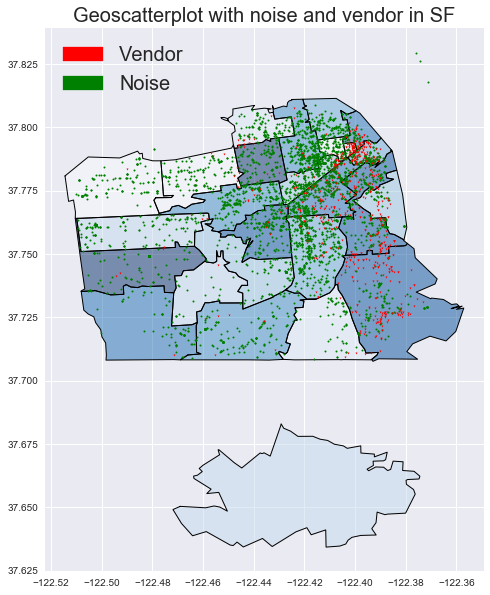

In [178]:
base = p.plot(cmap='Blues')
noise.plot(ax = base, marker = "o", color = "green")
vendor.plot(ax= base, marker = 'v', color = 'red')
red_patch = mpatches.Patch(color='red', label='Vendor')
green_patch = mpatches.Patch(color='green', label='Noise')
plt.legend(handles=[red_patch,green_patch],fontsize=20)
plt.title('Geoscatterplot with noise and vendor in SF',fontsize=20)

__1.2.4__ Is there a relationship between housing prices and any of the other tables?

For this question, based on previous analysis and common sense, I think that house price may be correalated with crime rates and other instructions like schools and parks. Also, median sold price seems to be a more reasonable index to reflect housing prices

In [195]:
query4='''
SELECT * FROM crime 
''' 
crime_all=pd.read_sql(query4, db)

In [198]:
lonlat = [geom.Point(lon, lat) for lon, lat in zip(crime_all.Lon, crime_all.Lat)]
crime1 = gpd.GeoDataFrame(crime_all, geometry = lonlat, crs = {'init' :'epsg:4326'})
crime1.geometry.head()

0     POINT (-122.42158168137 37.7617007179518)
1    POINT (-122.414406029855 37.7841907151119)
2    POINT (-122.414406029855 37.7841907151119)
3    POINT (-122.414406029855 37.7841907151119)
4    POINT (-122.431118543788 37.8004687042875)
Name: geometry, dtype: object

In [205]:
query0='SELECT * FROM '
q1=query0+'parks'

In [206]:
parks=pd.read_sql(q1, db)

In [ ]:
query4_1='''
SELECT * FROM parks 
''' 
parks=pd.read_sql(query4_1, db)
lonlat = [geom.Point(lon, lat) for lon, lat in zip(parks.Lon, parks.Lat)]
crime1 = gpd.GeoDataFrame(parks, geometry = lonlat, crs = {'init' :'epsg:4326'})
crime1.geometry.head()

In [ ]:
base = p_sold.plot(column='MedianSoldPricePerSqft_AllHomes',cmap='Blues',scheme='Quantiles',legend=True,k=9)
plt.title('GeoMap for Median Sold Price(per Sqft)',fontsize=20)
plt.show()

In [210]:
def geo_map(x,l1,l2):
    '''
    extract data from database and motify it into geodataframe.
    Args:x (string): table in data base
         l1,l2:columns of geodata in this table
    Returns: d geodataframe based on table x from database
    '''
    query='SELECT * FROM '+x
    data=pd.read_sql(q1, db)
    lonlat = [geom.Point(lon, lat) for lon, lat in zip(data[l1], data[l2])]
    d = gpd.GeoDataFrame(data, geometry = lonlat, crs = {'init' :'epsg:4326'})
    return d
geo_map('parks','Lon','Lat')

,Name,Type,Acreage,ParkID,Lat,Lon,geometry
0,10TH AVE/CLEMENT MINI PARK,Mini Park,0.66,156,37.781844,-122.468099,POINT (-122.46809908 37.78184397)
1,15TH AVENUE STEPS,Mini Park,0.26,185,37.759565,-122.472268,POINT (-122.47226783 37.75956493)
2,24TH/YORK MINI PARK,Mini Park,0.12,51,37.753060,-122.408575,POINT (-122.40857543 37.75306042)
3,29TH/DIAMOND OPEN SPACE,Neighborhood Park or Playground,0.82,194,37.743602,-122.435236,POINT (-122.43523589 37.74360211)
4,ADAM ROGERS PARK,Neighborhood Park or Playground,2.74,46,37.731016,-122.383855,POINT (-122.38385466 37.73101645)
5,ALAMO SQUARE,Neighborhood Park or Playground,12.70,117,37.776349,-122.434674,POINT (-122.43467396 37.77634875)
6,ALICE CHALMERS PLAYGROUND,Neighborhood Park or Playground,1.68,25,37.709827,-122.446651,POINT (-122.44665065 37.7098271)
7,ALICE MARBLE TENNIS COURTS,Neighborhood Park or Playground,0.84,151,37.801428,-122.420343,POINT (-122.42034327 37.80142776)
8,ALIOTO MINI PARK,Mini Park,0.16,62,37.758902,-122.418217,POINT (-122.41821702 37.75890196)
9,ALLYNE PARK,Neighborhood Park or Playground,0.75,131,37.797461,-122.427600,POINT (-122.42759992 37.79746066)


__1.2.5__ when and where to find the food truck?

In [186]:
query5='''
Select *,COUNT(DISTINCT L3.Address) AS COUNT FROM mobile_food_schedule As L1 INNER JOIN mobile_food_permits  AS L2
ON L1.permit = L2.permit 
INNER JOIN mobile_food_locations  AS L3 ON L1.locationid=L3.locationid
Group by L2.Applicant
ORDER BY COUNT DESC
'''
df5=pd.read_sql(query5, db)
df5

,locationid,permit,DayOfWeek,EndHour,StartHour,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration,locationid,LocationDescription,Address,Latitude,Longitude,COUNT
0,934630,17MFF-0110,Fr,11,10,17MFF-0110,REQUESTED,May Catering,Truck,Cold Truck: Sandwiches: fruit: snacks: candy: ...,1,None,2018-05-06 12:00:00,934630,EVANS AVE: HUNTERS POINT BLVD to JENNINGS ST \...,1059 EVANS AVE,37.736572,-122.378210,58
1,934668,17MFF-0111,Su,11,10,17MFF-0111,REQUESTED,Anas Goodies Catering,Truck,Cold Truck: Sandwiches: Noodles: Pre-packaged...,1,None,2018-03-04 12:00:00,934668,ELM ST: FRANKLIN ST to GOUGH ST (300 - 399),368 ELM ST,37.781380,-122.423144,37
2,437226,13MFF-0102,Fr,11,9,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00,437226,None,1650 03RD ST,37.769124,-122.391475,37
3,934485,17MFF-0090,Fr,7,6,17MFF-0090,REQUESTED,Liang Bai Ping,Truck,Cold Truck: Pre-packaged sandwiches: snacks: f...,1,None,2018-03-17 12:00:00,934485,GRIFFITH ST: QUESADA AVE to REVERE AVE (1300 -...,1300 GRIFFITH ST,37.727087,-122.381074,33
4,765710,16MFF-0051,Fr,13,0,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00,765710,BURKE AVE: END to 03RD ST (1500 - 1599),1575 BURKE AVE,37.744178,-122.386716,23
5,765538,16MFF-0048,Fr,18,17,16MFF-0048,REQUESTED,Singh Brothers Ice Cream,Truck,Ice Cream: Pre-Packaged Chips: Candies: Bottle...,1,None,2017-03-15 12:00:00,765538,PENINSULA AVE: BLANKEN AVE to LATHROP AVE (300...,360 PENINSULA AVE,37.710841,-122.399643,21
6,934429,17MFF-0084,Fr,16,15,17MFF-0084,REQUESTED,John's Catering #5,Truck,Cold Truck: Soda:Chips:Candy: Cold/Hot Sandwic...,1,None,2018-03-09 12:00:00,934429,11TH ST: KISSLING ST to BURNS PL (236 - 276),251 11TH ST,37.772497,-122.414210,19
7,559789,14MFF-0109,Fr,11,10,14MFF-0109,EXPIRED,Mang Hang Catering,Truck,COLD TRUCK. Deli: bbq chicken skewer: Chinese ...,1,None,2017-03-15 12:00:00,559789,ELLIS ST: LARKIN ST to POLK ST (700 - 799),730 ELLIS ST,37.784421,-122.418405,19
8,509496,14MFF-0001,Fr,11,10,14MFF-0001,EXPIRED,Sun Rise Catering,Truck,Cold Truck: sandwiches: drinks: snacks: candy:...,1,2014-09-10 12:00:00,2015-03-15 12:00:00,509496,NATOMA ST: RUSS ST to 07TH ST (547 - 599),560 NATOMA ST,37.779207,-122.409199,19
9,763604,16MFF-0037,Fr,11,10,16MFF-0037,APPROVED,D & T Catering,Truck,Cold Truck: Pre-packaged sandwiches: Chicken B...,1,2016-03-10 12:00:00,2017-03-15 12:00:00,763604,PACIFIC AVE: LYON ST to PRESIDIO AVE \ PRESIDI...,3100 PACIFIC AVE,37.792029,-122.446577,17
